In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("import tensorflow version " + tf.__version__)


# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Optimizer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization,
    LeakyReLU, Activation, Conv2DTranspose, Flatten, Dropout, Input, ZeroPadding2D
)
!pip install tensorflow-addons



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.1 MB/s eta 0:00:00


In [ ]:
# Path to the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/dataset'

# List to hold all the images
images = []

# Load and preprocess the images
for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(dataset_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image
        img = cv2.resize(img, (64, 64))

        # Normalize the image
        img = (img - 127.5) / 127.5

        images.append(img)

# Convert the list into a numpy array and add an extra dimension for the color channel
images = np.array(images)[..., np.newaxis]

In [ ]:
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.layers import LayerNormalization

from tensorflow.keras.layers import ELU
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers import Adamax

# The rest of your code for loading and preprocessing the images...

def build_generator(noise_dim=100):
    model = tf.keras.Sequential()

    initial_dim = 4
    model.add(tf.keras.layers.Dense(256 * initial_dim * initial_dim, activation='relu', input_dim=noise_dim))
    model.add(tf.keras.layers.Reshape((initial_dim, initial_dim, 256)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = tf.keras.Sequential()

    model.add(SpectralNormalization(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, input_shape=(64, 64, 1), padding='same')))
    model.add(ELU())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(SpectralNormalization(tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same')))
    model.add(InstanceNormalization())
    model.add(ELU())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(SpectralNormalization(tf.keras.layers.Conv2D(256, kernel_size=4, strides=2, padding='same')))
    model.add(InstanceNormalization())
    model.add(ELU())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(SpectralNormalization(tf.keras.layers.Conv2D(512, kernel_size=4, strides=2, padding='same')))
    model.add(InstanceNormalization())
    model.add(ELU())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


def sample_images(generator, epoch, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    # Show the plot
    plt.show()
    plt.close()


def train_gan(gan, generator, discriminator, images, epochs, batch_size=128):
    real = np.ones((batch_size, 1)) * 0.9  # One-sided label smoothing
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator (Twice as much as Discriminator)
        # ---------------------
        for _ in range(2):
            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = gan.train_on_batch(noise, real)

        print(f'{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]')

        # If at save interval => save generated image samples and model weights
        if epoch % 400 == 0:
            sample_images(generator, epoch)

        if epoch % 1000 == 0:  # Save model weights periodically
            generator.save_weights('generator_weights.h5')
            discriminator.save_weights('discriminator_weights.h5')






In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adamax(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)

gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=Adamax(0.0002, 0.5))

In [ ]:
train_gan(gan, generator, discriminator, images, epochs=5000, batch_size=128)

In [ ]:
# # Построение модели генератора и дискриминатора с той же архитектурой, что и ранее
# generator = build_generator()
# discriminator = build_discriminator()

# # Загрузка весов
# generator.load_weights('generator_weights.h5')
# discriminator.load_weights('discriminator_weights.h5')

# # Создание модели GAN и компиляция ее
# z = Input(shape=(100,))
# img = generator(z)

# discriminator.trainable = False
# valid = discriminator(img)

# gan = Model(z, valid)
# gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# # Продолжение обучения
# train_gan(gan, generator, discriminator, images, epochs=3000, batch_size=64)


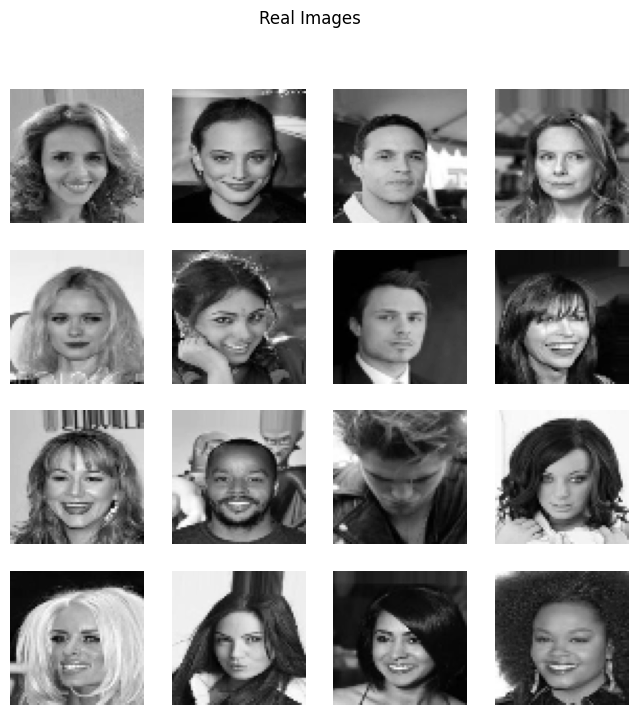

1/1 [==============================] - 0s 26ms/step


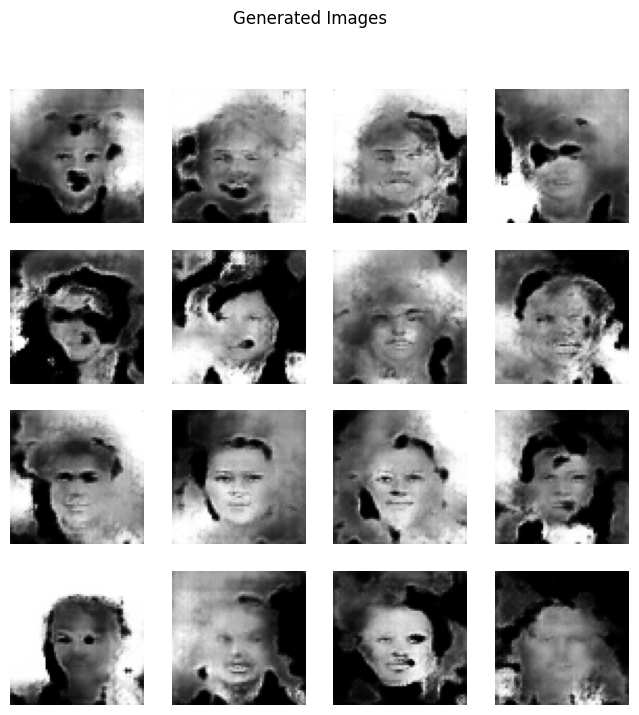

In [ ]:
def visualize_images(images, title):
    fig, axes = plt.subplots(4, 4, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow((images[i] * 127.5 + 127.5).astype(np.uint8), cmap="gray")
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize some real images from the dataset
# visualize_images(images[:16], 'Real Images')

# Generate a batch of noise vectors
noise = np.random.normal(0, 1, (16, 100))

# Use the generator to turn the noise vectors into images
generated_images = generator.predict(noise)

# Visualize the generated images
visualize_images(generated_images, 'Generated Images')